In [1]:
# --- 0. Install necessary library ---
#changed as recommended approach (!pip)-->(%pip) which equals to: python -m pip install <module>
#%pip install gdown pandas numpy scikit-learn matplotlib seaborn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # Keep for potential future use
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score
import gdown # Library to download from Google Drive
from sklearn.impute import SimpleImputer # Import imputer

# Define color codes
RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
BLUE = "\033[94m"
RESET = "\033[0m"  # Reset to default

In [3]:

# --- 1. Download Data from Google Drive ---
if False:
    file_id = '1dRE9RSdR3pCnDbr5iYHfH2sdR4hOdG3H'
    output_file = 'synthetic_data_loaded_with_header.csv' # Changed filename for clarity
    url = f'https://drive.google.com/uc?id={file_id}'

    print(f"Downloading file from Google Drive (ID: {file_id})...")
    try:
        # Using fuzzy=True might help if the direct download link changes slightly
        gdown.download(url, output_file, quiet=False, fuzzy=True)
        print(f"File saved as {output_file}")
    except Exception as e:
        print(f"Failed to download file: {e}")
        exit()

In [4]:
#Alternativelly use the combined SECOM dataset csv in the dataset subfolder
# Define the dataset folder path (the files are in a subfolder called dataset)
from pathlib import Path

dataset_folder = Path('dataset')
dataset_filename= 'SECOM_combined_dataset.csv'

print(f"Attempting to open the combined file {dataset_filename} saved locally in the folder {dataset_folder}")
try:
     output_file = dataset_folder / dataset_filename
     print(f'File successfully opened.')
except FileNotFoundError as e:
     print(f'File not found: {e}')
except Exception as e:
     print(e)

Attempting to open the combined file SECOM_combined_dataset.csv saved locally in the folder dataset
File successfully opened.


In [5]:
# --- 2. Load Data using Pandas (Assuming Header IS Present) ---
try:
    # FIX: Remove header=None to let Pandas read the first row as header
    data = pd.read_csv(output_file)
    print(f"Data loaded successfully from {output_file} with shape: {data.shape}")
    # Display first few rows and info to check data types
    print("\nFirst 5 rows of loaded data:")
    print(data.head())
    print("\nData info:")
    data.info()
except Exception as e:
    print(f"Failed to load data from {output_file}: {e}")
    exit()

Data loaded successfully from dataset\SECOM_combined_dataset.csv with shape: (1567, 591)

First 5 rows of loaded data:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0    3030.93    2564.00  2187.7333  1411.1265     1.3602      100.0   
1    3095.78    2465.14  2230.4222  1463.6606     0.8294      100.0   
2    2932.61    2559.94  2186.4111  1698.0172     1.5102      100.0   
3    2988.72    2479.90  2199.0333   909.7926     1.3204      100.0   
4    3032.24    2502.87  2233.3667  1326.5200     1.5334      100.0   

   feature_6  feature_7  feature_8  feature_9  ...  feature_581  feature_582  \
0    97.6133     0.1242     1.5005     0.0162  ...          NaN       0.5005   
1   102.3433     0.1247     1.4966    -0.0005  ...     208.2045       0.5019   
2    95.4878     0.1241     1.4436     0.0041  ...      82.8602       0.4958   
3   104.2367     0.1217     1.4882    -0.0124  ...      73.8432       0.4990   
4   100.3967     0.1235     1.5031    -0.0031  ...    

In [6]:
# --- 3. Prepare Data ---
if data.shape[1] > 1:
    # Assume last column is target 'y', all others are features 'X'
    feature_names = data.columns[:-1].tolist() # Get actual feature names from header
    X_df = data[feature_names] # Select feature columns using names
    y_series = data.iloc[:, -1] # Select target column by position

    print(f"\nFeature names extracted from header: {feature_names[:5]}... (Total: {len(feature_names)})")

    # --- Keep Robust Cleaning Steps ---
    # Convert non-numeric strings to numeric, coercing errors, otherwise-> NaN
    X_df_numeric = X_df.apply(pd.to_numeric, errors='coerce')
    y_series_numeric = pd.to_numeric(y_series, errors='coerce')

    # Handle potential NaN values resulting from coercion or missing values in original file
    imputer_X = SimpleImputer(strategy='mean')
    X_imputed = imputer_X.fit_transform(X_df_numeric)

    missing_labels_count = y_series_numeric.isna().sum()
    
    imputer_y = SimpleImputer(strategy='most_frequent') #changed strategy from mean to most frequent since we have binary labels
    y_imputed = imputer_y.fit_transform(y_series_numeric.values.reshape(-1, 1)).flatten()

    # Check for NaNs after imputation (should only happen if a whole column was non-numeric/NaN)
    if np.isnan(X_imputed).any() or np.isnan(y_imputed).any():
        print("Warning: NaNs still present after imputation. Check columns with all invalid values.")
        # Consider more advanced imputation or dropping problematic columns/rows if this occurs

    X = X_imputed
    y = y_imputed

    print(f"Features shape after cleaning: {X.shape}")
    
    print(f"Number of missing labels to be imputed: {missing_labels_count}")
    print(f"Target shape after cleaning: {y.shape}")
    n_features_loaded = X.shape[1] # Keep track of the number of features

else:
    print("Error: Loaded data has only one column. Cannot separate features and target.")
    exit()


Feature names extracted from header: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']... (Total: 590)
Features shape after cleaning: (1567, 590)
Number of missing labels to be imputed: 0
Target shape after cleaning: (1567,)


In [7]:

# --- 4. Split Data for Fitness Evaluation ---
# Using the cleaned X and y, with stratify helps maintain the proportion of class labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
n_features = X_train.shape[1] # Use the actual number of features
print(f"\nTraining features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")



Training features shape: (1096, 590)
Validation features shape: (471, 590)


In [8]:
#To visualize the distribution of the labels, in the case of SECOM is imbalanced
def plotLabelsDistribution(label_array, data_name='default_name'):
    data = pd.DataFrame({'label': label_array})

    # Count the occurrences of each class
    class_counts = data['label'].value_counts().sort_index()
    class_percentages = class_counts / class_counts.sum() * 100

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(6,4))
    #sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis", hue=class_counts, legend=False)

    plt.title(f'Class Distribution for {data_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Annotate counts and percentages on bars
    for i, (count, perc) in enumerate(zip(class_counts.values, class_percentages.values)):
        plt.text(i, count + max(class_counts.values)*0.01, f'{count} ({perc:.1f}%)', 
                ha='center', va='bottom', fontsize=10)

    plt.show()


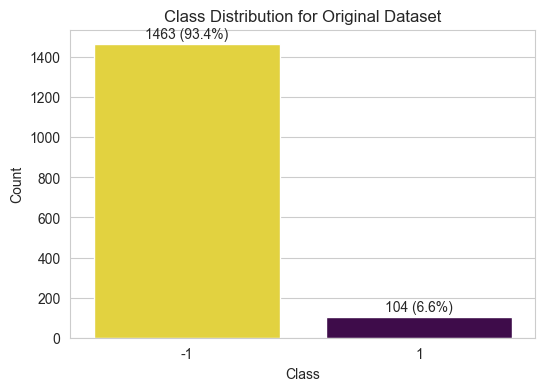

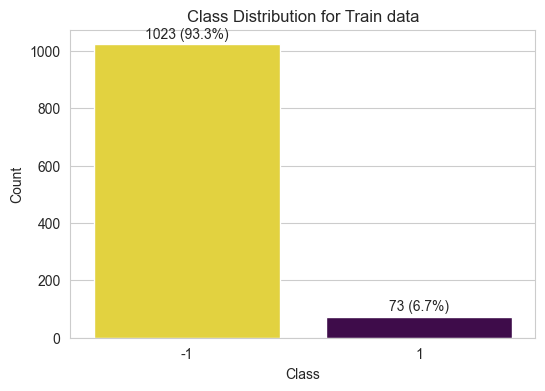

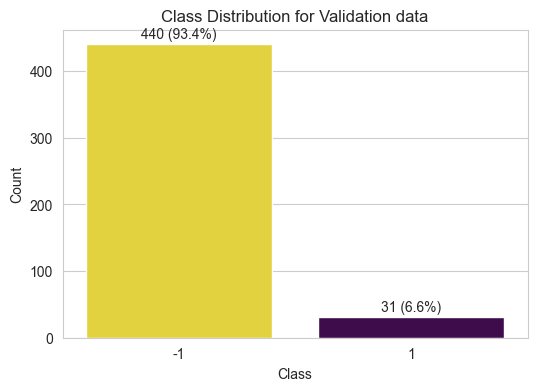

In [9]:
#plot LAbel distributions
plotLabelsDistribution(y,'Original Dataset')
plotLabelsDistribution(y_train,'Train data')
plotLabelsDistribution(y_val,'Validation data')

In [10]:
# --- Fitness Function (using Random Forest) ---
def fitness_function(individual, model, penalty_coef, num_desired_features):
    individual = np.array(individual)  #Ensure it's a NumPy array
    selected_indices = np.where(individual == 1)[0] # Get indices where bit is 1
    num_selected_features = len(selected_indices)

    #TODO: This validation can be done before calling this function!!!!!!!!!
    if num_selected_features == 0:
        return -np.inf # Heavily penalize empty feature set

    # Select corresponding columns from train/validation sets
    X_train_sel = X_train[:, selected_indices]
    X_val_sel = X_val[:, selected_indices]
    
    try:        
        model.fit(X_train_sel, y_train)
        y_pred = model.predict(X_val_sel)
        
        # Fitness = Negative MSE (maximization) - Penalty for feature count
        #mse = mean_squared_error(y_val, y_pred)        
        #fitness = -mse - penalty_coef * num_selected_features
        #score = mean_squared_error(y_val, y_pred)        

        #f1 score more suitable for imbalanced (binary) datsaet
        #penalty discourages solutions that are significantly larger or smaller than the target subset size 
        score = f1_score(y_val,y_pred,average='binary', pos_label=1)
        penalty = penalty_coef*abs(num_selected_features - num_desired_features)
        
        fitness = score - penalty

    except ValueError as e:
        # Catch potential errors during fitting/prediction if data issues remain
        print(f"Error during model fitting/prediction: {e}")
        fitness = -np.inf # Penalize if model fails
    return fitness

In [11]:
#Evaluate fitness population in parallel and saves each new pair individual,fitness in cache, population is pre-filtered
#so only individuals not in the cache are actually calculated
#could be improved if saved to disk, but then must review dataset splitting process.
from joblib import Parallel, delayed
from tqdm import tqdm

def evaluate_population(num_desired_features, population, classif_model, penalty, fitness_cache=None, n_jobs=-1, batch_size=10):
    print(f'\tEvaluating population fitness in parallel (batch_size={batch_size})..')

    if fitness_cache is None:
        fitness_cache = {}

    # Convert individuals to hashable keys
    keys = [tuple(ind) for ind in population]

    # Find unique individuals that still need evaluation
    unique_to_eval = list(set(k for k in keys if k not in fitness_cache))

    print(f"\tThere are {len(unique_to_eval)} new individuals to evaluate (cached: {len(keys) - len(unique_to_eval)})")

    # Parallel evaluation only on new individuals
    new_fitnesses = Parallel(n_jobs=n_jobs, batch_size=batch_size)(
        delayed(fitness_function)(list(ind), classif_model, penalty, num_desired_features) 
        for ind in unique_to_eval
    )

    # Update cache
    for k, fit in zip(unique_to_eval, new_fitnesses):
        fitness_cache[k] = fit

    # Build final fitness array corresponding to input population
    fitness_list  = [fitness_cache[k] for k in keys] #<----previous result if it breaks just return this instead of the df

    #Build DataFrame so later be easier to order individuals per fitness, but must maintain the other code.
    df_fitness_individuals = pd.DataFrame({
        'fitness': fitness_list ,
        'bits': [np.array(ind) for ind in keys]  # convert individuals back to np.array
    })
    #Sort by fitness descending (best first)
    df_fitness_individuals = df_fitness_individuals.sort_values(by='fitness', ascending=False).reset_index(drop=True)
    return df_fitness_individuals, fitness_cache


In [12]:
#The expected number of selected features is d ⊆ n_features, this constraint must be set up since the first population
# to make more likely for the algorithm to focus on small subsets instead of larger ones in further generations.
#We set the chance of each gene being 1 in the initial population P to a value of d/D
def initialize_population(d, pop_size, n_features):
    probability_for_1 = d/n_features
    probability_for_0 = 1 - probability_for_1
    
    print(f'-Building Initial population of size: {pop_size} with approximately {d} features per individual')
    
    pop = np.random.choice([0, 1], size=(pop_size, n_features), p=[probability_for_0, probability_for_1])    
    
    # Ensure initial individuals are not all zeros
    for i in range(pop_size):
        if not pop[i].any:
            #then randomly sets one feature to 1.
            pop[i, np.random.randint(0, n_features)] = 1
    return pop

#TEST:
if False:
    print(f'TESTING:---------')
    pop_test = initialize_population(5, 10, 10)
    print(f'output shape:{pop_test.shape}')
    print(f'output:{pop_test}')

In [13]:
#Returns array of len(pop) individuals each one is selected by tournament
#Each tournament round is won by the individual with the higest fitness and that winner goes to the result
def tournament_selection(pop, fitnesses, k=3):
    # Handle potential -inf fitness values gracefully
    valid_indices = np.where(np.isfinite(fitnesses))[0]
    if len(valid_indices) == 0:
        # If no individuals have valid fitness, return random individuals to avoid crash
        print("Warning: No individuals with valid fitness in selection.")
        return pop[np.random.choice(len(pop), size=len(pop))]
    if len(valid_indices) < k:
        # If fewer valid individuals than tournament size, select randomly from valid ones
        selected_idx = np.random.choice(valid_indices, size=len(pop), replace=True) # Allow replacement
        return pop[selected_idx]

    selected = []
    for _ in range(len(pop)):
       # Ensure tournament participants are chosen only from valid individuals
       tournament_contenders_indices = np.random.choice(valid_indices, k, replace=False)
       winner_idx_in_contenders = np.argmax(fitnesses[tournament_contenders_indices])
       winner_original_idx = tournament_contenders_indices[winner_idx_in_contenders]
       selected.append(pop[winner_original_idx])
    return np.array(selected)

In [14]:
# --- Local Search ---
# (This function remains unchanged structurally)
def local_search(individual, num_desired_features, steps, model, penalty): # Uses tuned steps
    best = individual.copy()
    current_fitness = fitness_function(best, model, penalty, num_desired_features)
    # Cannot perform local search on invalid individual
    if not np.isfinite(current_fitness):
        return best

    indices_to_try = np.arange(len(best))
    for _ in range(steps):
        np.random.shuffle(indices_to_try)
        improved_in_step = False
        for idx in indices_to_try:
            candidate = best.copy()
            candidate[idx] = 1 - candidate[idx] # Flip bit
            # Ensure candidate is not all zeros
            if np.sum(candidate) == 0:
                continue # Skip invalid (all zero) candidate
            candidate_fitness = fitness_function(candidate, model, penalty, num_desired_features)
            # Only accept improvement if candidate_fitness is valid and better
            if np.isfinite(candidate_fitness) and candidate_fitness > current_fitness:
                best = candidate
                current_fitness = candidate_fitness
                improved_in_step = True
                break # Move to next step once an improvement is found (first improvement)
        if not improved_in_step:
            break # Stop if no single flip improved fitness in a full pass
    return best

In [15]:
def keepBestFitnessRecord(gen, valid_fitness_indices, fitnesses, population, best_individual_overall, best_fit_overall, best_fitnesses, features_selected_history):
    
    if len(valid_fitness_indices) > 0:         
        gen_best_idx_among_valid = np.argmax(fitnesses[valid_fitness_indices])
        gen_best_original_idx = valid_fitness_indices[gen_best_idx_among_valid]
        gen_best_fitness = fitnesses[gen_best_original_idx]

        # Update overall best
        if gen_best_fitness > best_fit_overall:
            best_fit_overall = gen_best_fitness
            best_individual_overall = population[gen_best_original_idx].copy()

        # Store history based on overall best
        best_fitnesses.append(best_fit_overall)
        features_selected_history.append(np.sum(best_individual_overall) if best_individual_overall is not None else 0)

        #print(f'\tBest Fitness: {best_fitnesses}')
    elif len(valid_fitness_indices) == 0:
        #"Warning: No valid individuals in generation it should be Stopping early the GA loop
        # Keep the last known best if available, otherwise end with None
        best_fitnesses.append(best_fit_overall if np.isfinite(best_fit_overall) else np.nan)
        features_selected_history.append(np.sum(best_individual_overall) if best_individual_overall is not None else 0)
    
    return best_individual_overall, best_fit_overall, best_fitnesses, features_selected_history

ELITISM:

In [16]:
#n_elite: number of elite individuals to be kept??
def getEliteIndividuals(n_elite, population, fitnesses, valid_fitness_indices):  
    print(f'\tAplying Elitism..')
    sorted_valid_indices = valid_fitness_indices[np.argsort(fitnesses[valid_fitness_indices])]
    elite_indices = sorted_valid_indices[-n_elite:]
    elites = population[elite_indices].copy()
    return elites  

#Checks for valid offspring, sorts, pick the worst and replace with elites
#TODO: To check if this is properly working for f1_score based fitness
def applyElitismToOffspring(fitnesses_offspring_post_ls, n_elite, elites, offspring):    
    valid_offspring_indices_post_ls = np.where(np.isfinite(fitnesses_offspring_post_ls))[0]
    if len(valid_offspring_indices_post_ls) >= n_elite:
        sorted_valid_offspring_indices_post_ls = valid_offspring_indices_post_ls[np.argsort(fitnesses_offspring_post_ls[valid_offspring_indices_post_ls])]
        worst_indices = sorted_valid_offspring_indices_post_ls[:n_elite]
        num_to_replace = min(len(worst_indices), len(elites))
        offspring[worst_indices[:num_to_replace]] = elites[:num_to_replace]
    return offspring

CROSSOVER & MUTATION:

In [17]:
# Crossover & Mutation ORIGINALS
def crossoverAndMutation_Original(population, pop_size,selected_parents, crossover_rate, mutation_rate):
    offspring = np.empty_like(population)
    for i in range(0, pop_size, 2): # Uses tuned POP_SIZE
        p1_idx, p2_idx = i, (i + 1) % pop_size
        parent1, parent2 = selected_parents[p1_idx], selected_parents[p2_idx]
        if np.random.rand() < crossover_rate:
            child1 = uniform_crossover(parent1, parent2)
            child2 = uniform_crossover(parent2, parent1)
        else:
            child1, child2 = parent1.copy(), parent2.copy()
        offspring[i] = mutate(child1, mutation_rate)
        if i + 1 < pop_size:
            offspring[i+1] = mutate(child2, mutation_rate)
    return offspring

def uniform_crossover(parent1, parent2):
    mask = np.random.randint(0, 2, size=len(parent1), dtype=bool)
    child = np.where(mask, parent1, parent2)
    return child

def mutate(individual, mutation_rate):
    mutant = individual.copy()
    mutation_mask = np.random.rand(len(mutant)) < mutation_rate
    mutant[mutation_mask] = 1 - mutant[mutation_mask] # Flip bits
    # Ensure mutation doesn't result in an all-zero individual
    if np.sum(mutant) == 0 and len(mutant) > 0:
         mutant[np.random.randint(0, len(mutant))] = 1
    return mutant

In [18]:
import numpy as np

def m_point_crossover(population, selected_pairs, m):
    """
    Apply m-point crossover to selected parent pairs in a vectorized way.

    Args:
        population (np.ndarray): Full population, shape (pop_size, chromosome_length)
        selected_pairs (np.ndarray): Array of selected parent indexes, shape (num_pairs, 2)
        m (int): Number of crossover points (must be >=1)

    Returns:
        offspring1, offspring2 (np.ndarray): Two offspring populations (shape: num_pairs x chromosome_length)
    """
    num_pairs = selected_pairs.shape[0]
    chrom_length = population.shape[1]
    
    assert m >= 1, "Number of crossover points must be at least 1"
    assert m < chrom_length, "Number of crossover points must be less than chromosome length"
    
    # Extract the selected parent chromosomes
    parents1 = population[selected_pairs[:, 0]]
    parents2 = population[selected_pairs[:, 1]]
    
    # Generate random cutting points for each pair
    cuts = np.sort(
        np.random.randint(1, chrom_length, size=(num_pairs, m)),
        axis=1
    )
    
    # Initialize offspring arrays
    offspring1 = np.empty_like(parents1)
    offspring2 = np.empty_like(parents2)
    
    pos = np.arange(chrom_length)
    
    for i in range(num_pairs):
        seg = np.zeros(chrom_length, dtype=int)
        for cut in cuts[i]:
            seg[pos >= cut] += 1
        # Alternate segments: even segments from parent1, odd from parent2
        mask = seg % 2 == 0
        offspring1[i] = np.where(mask, parents1[i], parents2[i])
        offspring2[i] = np.where(mask, parents2[i], parents1[i])

    return offspring1, offspring2


In [19]:
# Crossover & Mutation as on the Paper vectorized to process the entire population
def controlled_mutation_population(population, mutation_rate):
    """
    Apply controlled mutation to an entire population.    
    Scaling p0 using the ratio n1 / n0 makes sure that, on average, 
    the number of genes flipping from 1 → 0 and from 0 → 1 is similar.
	So, the total number of selected items (1s) stays roughly constant, even after mutation.
    population: shape (num_individuals, num_genes), with 0s and 1s
    mutation_rate: base mutation rate (e.g., 0.01)    
    """
    mutant_pop = population.copy()

    # Sum number of 0s and 1s for each individual (along axis=1)
    n0 = np.sum(mutant_pop == 0, axis=1, keepdims=True)  # shape (num_individuals, 1)
    n1 = np.sum(mutant_pop == 1, axis=1, keepdims=True)

    # Avoid division by zero
    n0_safe = np.where(n0 == 0, 1, n0)

    p1 = mutation_rate  # 1 → 0
    p0 = mutation_rate * (n1 / n0_safe)  # 0 → 1

    # Generate random values for all genes in all individuals
    random_vals = np.random.rand(*mutant_pop.shape)

    # Create masks
    mask1 = (mutant_pop == 1) & (random_vals < p1)  # flip 1 → 0
    mask0 = (mutant_pop == 0) & (random_vals < p0)  # flip 0 → 1

    # Apply mutation
    mutant_pop[mask1] = 0
    mutant_pop[mask0] = 1

    # Ensure no individual becomes all-zero
    sums = np.sum(mutant_pop, axis=1)
    zero_inds = np.where(sums == 0)[0]
    for idx in zero_inds:
        gene_idx = np.random.randint(0, mutant_pop.shape[1])
        mutant_pop[idx, gene_idx] = 1

    return mutant_pop

SELECTION MECHANISM

In [20]:
import numpy as np
import pandas as pd

def rank_based_selection(df, q, num_pairs):
    """
    Selects pairs of parents using rank-based roulette wheel selection.

    Parameters:
    - df: DataFrame sorted by fitness descending.
    - q: Selection pressure parameter (0 < q < 1).
    - num_pairs: Number of parent pairs to select.

    Returns:
    - NumPy array of shape (num_pairs, 2) with selected parent indexes.
    """
    n = len(df)
    
    # Step 1: Calculate selection probabilities using P(i) = q * (1 - q)^(i - 1)
    P = np.array([q * (1 - q) ** i for i in range(n)])  # i from 0 to n-1
    
    # Calculate cumulative probabilities p_i
    cumulative_probs = np.cumsum(P)
    
    selected_indexes = np.zeros((num_pairs, 2), dtype=int)
    
    for pair_idx in range(num_pairs):
        for parent_idx in range(2):  # select two parents per pair
            r = np.random.uniform(0, cumulative_probs[-1])
            i = np.searchsorted(cumulative_probs, r)
            selected_indexes[pair_idx, parent_idx] = i
    
    return selected_indexes

#TEsting:
#population_test = initialize_population(d_features=30, pop_size=100, n_features=n_features)

In [21]:
def control_genetic_operations(
    selected_pairs, m_crossover, mutation_rate, df_current_population, d_features,
    classif_model,
    penalty,
    fitness_cache,
    strategy='generational'
):
    """
    Controls genetic operations using steady-state or generational strategy.
    Returns:
        df_offspring: DataFrame same shape as df_fitness_individuals
    """
     # Always force bits to 2D int numpy array
    population = np.vstack(df_current_population['bits'].apply(lambda x: np.array(x, dtype=int)).to_numpy())

    # 1. Apply crossover
    offspring1, offspring2 = m_point_crossover(population, selected_pairs, m_crossover)
    offspring_pop = np.vstack((offspring1, offspring2))

    # 2. Apply mutation
    offspring_pop = controlled_mutation_population(offspring_pop, mutation_rate)

    # 3. Evaluate offspring
    df_offspring_fitness, fitness_cache = evaluate_population(
        d_features, offspring_pop, classif_model, penalty, fitness_cache, n_jobs=-1, batch_size=10
    )

   # Convert population bits to list-of-arrays for safe matching
    current_pop_bits = [np.array(ind, dtype=int) for ind in population]

    if strategy == 'generational':
        # Replace entire population with offspring
        df_offspring = df_offspring_fitness.copy()

    elif strategy == 'steady_state':
        # The new population is first initialized with the current population
        new_population = current_pop_bits.copy()
        df_new_fitness = df_current_population.copy()

        # Go through offspring one by one
        for i, offspring_bits in enumerate(df_offspring_fitness['bits'].apply(lambda x: np.array(x, dtype=int))):
            offspring_fitness = df_offspring_fitness.iloc[i]['fitness']

            # Find parents
            pair_idx = i // 2  # 2 offspring per pair
            parent1_bits = population[selected_pairs[pair_idx][0]]
            parent2_bits = population[selected_pairs[pair_idx][1]]

            # Parent fitness lookup
            parent1_fitness = df_current_population[
                df_current_population['bits'].apply(lambda x: np.array_equal(np.array(x, dtype=int), parent1_bits))
            ].iloc[0]['fitness']
            parent2_fitness = df_current_population[
                df_current_population['bits'].apply(lambda x: np.array_equal(np.array(x, dtype=int), parent2_bits))
            ].iloc[0]['fitness']

            # Decide replacement
            if offspring_fitness > max(parent1_fitness, parent2_fitness):
                target_bits = parent1_bits if parent1_fitness < parent2_fitness else parent2_bits
            elif min(parent1_fitness, parent2_fitness) < offspring_fitness <= max(parent1_fitness, parent2_fitness):
                target_bits = parent1_bits if parent1_fitness < parent2_fitness else parent2_bits
            else:
                worst_idx = df_new_fitness['fitness'].idxmin()
                target_bits = np.array(df_new_fitness.iloc[worst_idx]['bits'], dtype=int)

            # Find index to replace safely
            found = False
            for idx, bits in enumerate(new_population):
                if np.array_equal(bits, target_bits):
                    replace_idx = idx
                    found = True
                    break

            if not found:
                raise ValueError("Replacement failed: No matching bits found.")

            new_population[replace_idx] = offspring_bits
            df_new_fitness.at[replace_idx, 'fitness'] = offspring_fitness
            df_new_fitness.at[replace_idx, 'bits'] = offspring_bits.tolist()

        df_offspring = df_new_fitness.copy()

    else:
        raise ValueError("Unknown strategy. Use 'generational' or 'steady_state'")

    return df_offspring, fitness_cache


In [22]:
#For keep record of the best individuals of each experiment and later save to disk
from bestracker import BestTracker
def resultsTrackerFunction(results_tracker:BestTracker, current_best_fitness, current_best_individual, 
                        current_best_number_of_features, generation, crossover_operator_point, 
                        mutation_coef, population_size, selection_coef, strategy, expectedFitness, 
                        classif_model, goal_features_number, penalty_coef, num_elite, crossover_rate,
                        max_gen, best_individual_overall):
    
    results_tracker.update(
        fitness= current_best_fitness,
        features= current_best_individual,
        number_of_features= current_best_number_of_features,
        generation= generation,
        selection_coef= selection_coef,
        crossover_operator_point= crossover_operator_point,
        crossover_rate= crossover_rate,
        mutation_coef= mutation_coef,
        penalty_coef= penalty_coef,
        population_size= population_size,
        strategy= strategy,
        num_elite= num_elite,
        expectedFitness= expectedFitness,
        classif_model= classif_model,
        goal_features_number= goal_features_number,
        max_gen= max_gen
    )

    #If the current fitness is greater than the overall so far, updates.
    if (best_individual_overall is None) or (current_best_fitness > best_individual_overall['fitness']):
        best_individual_overall = {
            'fitness': current_best_fitness,
            'features': current_best_individual,
            'number_of_features': current_best_number_of_features,
            'generation': generation
        }

    return best_individual_overall

In [23]:
# --- 5. Hybrid Genetic Algorithm for Feature Selection ---
# --- Main HGA Loop ---
#d_features: Desired features

def hybrid_ga_feature_selection(d_features, pop_size, n_gen, classif_model, penalty, elitism, n_elite, crossover_rate, mutation_rate,
                                 ls_top_k, local_search_steps, fitness_cache):
    
    best_fitnesses = []
    best_individual_overall = None
    best_fit_overall = -np.inf
    features_selected_history = []
    
    population = initialize_population(d_features, pop_size, n_features)
    print("\nStarting Hybrid Genetic Algorithm...")
    for gen in range(n_gen): # Uses tuned N_GEN
        print(f'\n-Running Generation: {gen+1}----')        
        # Evaluate fitness for the current population
        print(f'\tEvaluating population fitness..')
        #fitnesses = np.array([fitness_function(ind, classif_model, penalty) for ind in population])          
        df_fitness_individuals, fitness_cache = evaluate_population(d_features, population, classif_model, penalty, fitness_cache, n_jobs=-1, batch_size=10)      
        fitnesses = df_fitness_individuals['fitness'].values
        #--------------------------------------------------------------------------------------------------------
        # Find best valid individual in generation
        print(f'\tFinding best valid individual..')
        #To Filter those individuals which could have -inf fitness
        valid_fitness_indices = np.where(np.isfinite(fitnesses))[0]
        best_individual_overall, best_fit_overall, best_fitnesses, features_selected_history =\
        keepBestFitnessRecord(gen, valid_fitness_indices, fitnesses, population, best_individual_overall, best_fit_overall, best_fitnesses, features_selected_history)

        if len(valid_fitness_indices) == 0: 
            print(f"Warning: No valid individuals in generation {gen+1}. Stopping early.")         
            break # Stop the GA run              
        #----------------------------------------------------------------------------------
        #For debugging:--------------------------------------------------------------------
        print(f'\tfitnesses[valid_fitness_indices]: {fitnesses[valid_fitness_indices]}')
        #print(f'\tBest Fitness: {best_fitnesses}')  
        #----------------------------------------------------------------------------------        
        #--- GA Operators (Selection, Crossover, Mutation) ---
        # Elitism
        if elitism: elites = getEliteIndividuals(n_elite, population, fitnesses, valid_fitness_indices)
        else: elites = np.empty((0, n_features), dtype=int)
        #---------------------------------------------------------------------------------
        # Selection
        print(f'\tSelecting parents by {tournament_selection.__name__}...')
        selected_parents = tournament_selection(population, fitnesses)
        #---------------------------------------------------------------------------------        
        # Crossover & Mutation
        print(f'\tApplying Crossover and Mutation operators...')
        offspring = crossoverAndMutation_Original(population, pop_size,selected_parents, crossover_rate, mutation_rate)
        #---------------------------------------------------------------------------------
        # Local Search on top K individuals (uses tuned LS_TOP_K)
        #fitnesses_offspring_pre_ls = np.array([fitness_function(ind, classif_model, penalty) for ind in offspring])
        df_fitness_individuals, fitness_cache = evaluate_population(d_features, offspring, classif_model, penalty, fitness_cache, n_jobs=-1, batch_size=10)      
        fitnesses_offspring_pre_ls = df_fitness_individuals['fitness'].values
        valid_offspring_indices = np.where(np.isfinite(fitnesses_offspring_pre_ls))[0]

        if len(valid_offspring_indices) > 0:
             sorted_valid_offspring_indices = valid_offspring_indices[np.argsort(fitnesses_offspring_pre_ls[valid_offspring_indices])]
             top_indices_for_ls = sorted_valid_offspring_indices[-ls_top_k:] # Uses tuned LS_TOP_K
             print(f'\tApplying Local Search...')
             for idx in top_indices_for_ls:
                 # Uses tuned LOCAL_SEARCH_STEPS inside the function call
                 offspring[idx] = local_search(offspring[idx], d_features, local_search_steps, classif_model, penalty) 

        # Replacement with Elitism        
        if elitism and len(elites) > 0:
            print(f'\tObtaining offspring with Elitism...')
            #fitnesses_offspring_post_ls = np.array([fitness_function(ind, classif_model, penalty) for ind in offspring])
            df_fitness_individuals, fitness_cache = evaluate_population(d_features, offspring, classif_model, penalty, fitness_cache, n_jobs=-1, batch_size=10)      
            fitnesses_offspring_post_ls = df_fitness_individuals['fitness'].values
            offspring = applyElitismToOffspring(fitnesses_offspring_post_ls, n_elite, elites, offspring)

        population = offspring

        current_best_features = np.sum(best_individual_overall) if best_individual_overall is not None else 0
        #print(f"Result for Generation {gen+1}/{n_gen}: Best Fitness = {best_fit_overall:.4f}, Features Selected = {current_best_features}")
        print(f"{GREEN}Result for Generation {gen+1}/{n_gen}:{RESET} {YELLOW}Best Fitness = {best_fit_overall:.4f}{RESET}, {BLUE}Features Selected = {current_best_features}{RESET}")
        print('-'*30)

    print("Hybrid Genetic Algorithm finished.")
    return best_individual_overall, best_fitnesses, features_selected_history, fitness_cache



FOR DEBUGGING:

In [45]:


# GA Parameters (TUNED for potentially faster runtime)
# --- TUNING POINT ---
POP_SIZE = 100 # Reduced from 30
N_GEN = 100    # Reduced from 30
# --- TUNING POINT ---
CROSSOVER_RATE = 1 # Kept the same - Not used in paper research apparently
MUTATION_RATE = 0.05  # Kept the same
ELITISM = False       # Kept the same
N_ELITE = 1          # Kept the same
# --- TUNING POINT ---
LOCAL_SEARCH_STEPS = 1 # Reduced from 5
LS_TOP_K = 2          # Reduced from 3
# --- TUNING POINT ---
PENALTY_COEFF = 0.0001   # Kept the same

DESIRED_FEATURES_NUMBER = 35

# DEfine the Classifier model: Random Forest
# --- TUNING POINT ---
# Use fewer estimators for significantly faster fitness evaluation
model = RandomForestClassifier(n_estimators=15, # Reduced from 50
                                random_state=42,
                                n_jobs=-1) # Use n_jobs=-1 for parallelization
# --- TUNING POINT ---

#memoization: cache for pairs: individual,fitness to avoid recalculations
fitness_cache = {}
best_fitnesses = []
best_individual_overall = None
best_fit_overall = -np.inf
features_selected_history = []
#testing------
gen=0
q=0.6 #roulette-wheel selection coeficient
m_crossover=3   #crossover operator points
#strategy = "steady_state"  -->TODO: Not working
strategy = "generational"
expectedFitness = 0.5
results_tracker = BestTracker() #for keeping track of best fitness per generation on a file

initial_population = initialize_population(DESIRED_FEATURES_NUMBER, POP_SIZE, n_features=n_features)
print("\nStarting Hybrid Genetic Algorithm TESTªªª...")
print(f'df_offspring with a {strategy} strategy')
print(f'\tEvaluating Initial population fitness..')
df_current_population, fitness_cache = evaluate_population(DESIRED_FEATURES_NUMBER, population=initial_population, classif_model=model, penalty=PENALTY_COEFF, fitness_cache=fitness_cache, n_jobs=-1, batch_size=10)      
current_best_fitness = df_current_population['fitness'].iloc[0]
current_best_individual= np.array(df_current_population['bits'].iloc[0], dtype=int)
current_best_number_of_features = np.sum(current_best_individual)
best_individual_overall = resultsTrackerFunction(results_tracker, current_best_fitness, current_best_individual, 
                        current_best_number_of_features, gen, m_crossover, MUTATION_RATE, POP_SIZE, 
                        q, strategy, expectedFitness, model, DESIRED_FEATURES_NUMBER,
                        PENALTY_COEFF, N_ELITE, CROSSOVER_RATE, N_GEN, best_individual_overall)

print(f"{GREEN}Initial Population: {gen}/{N_GEN}:{RESET} {YELLOW}Best Current Fitness = {current_best_fitness:.4f}{RESET}, {BLUE}With Features Selected = {current_best_number_of_features}{RESET}")
#--------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
#For debugging:--------------------------------------------------------------------
#print(f'\tfitnesses[valid_fitness_indices]: {fitnesses[valid_fitness_indices]}')
#print(f'\tBest Fitness: {best_fitnesses}')  
#print(f'\ndf_fitness:\n {df_current_population}')
#----------------------------------------------------------------------------------      

# THE LOOP WOULD START AROUND HERE
gen = 1
while  (current_best_fitness <= expectedFitness) and (gen <= N_GEN) :
    #--- GA Operators (Selection, Crossover, Mutation) ---
    selected_parents_test = rank_based_selection(df_current_population, q, 50)    

    df_offspring, fitness_cache =control_genetic_operations(selected_parents_test, m_crossover, MUTATION_RATE, df_current_population, DESIRED_FEATURES_NUMBER,
                                model, PENALTY_COEFF, fitness_cache, strategy)
    #print(f'\ndf_offspring with a {strategy} strategy:\n {df_offspring}')
    #replacement of the current population for the offspring
    df_current_population = df_offspring    
    #current_best_features = np.sum(best_individual_overall) if best_individual_overall is not None else 0    
    current_best_fitness = df_current_population['fitness'].iloc[0]
    current_best_individual= np.array(df_current_population['bits'].iloc[0], dtype=int)
    current_best_number_of_features = np.sum(current_best_individual)
    best_individual_overall = resultsTrackerFunction(results_tracker, current_best_fitness, current_best_individual, 
                        current_best_number_of_features, gen, m_crossover, MUTATION_RATE, POP_SIZE, 
                        q, strategy, expectedFitness, model, DESIRED_FEATURES_NUMBER,
                        PENALTY_COEFF, N_ELITE, CROSSOVER_RATE, N_GEN, best_individual_overall)
    
    print(f"{GREEN}Current Population: {gen}/{N_GEN}:{RESET} {YELLOW}Best Current Fitness = {current_best_fitness:.4f}{RESET}, {BLUE}With Features Selected = {current_best_number_of_features}{RESET}")
    print('-'*30)
    gen = gen +1

print("Hybrid Genetic Algorithm finished.")
print(f'Best solution found--> fitness: {best_individual_overall['fitness']:.4f}, Number of features:{best_individual_overall['number_of_features']} at generation: {best_individual_overall['generation']}')
#return best_individual_overall, best_fitnesses, features_selected_history, fitness_cache

#Save experiment resuls to disk
results_tracker.save()

-Building Initial population of size: 100 with approximately 35 features per individual

Starting Hybrid Genetic Algorithm TESTªªª...
df_offspring with a generational strategy
	Evaluating Initial population fitness..
	Evaluating population fitness in parallel (batch_size=10)..
	There are 100 new individuals to evaluate (cached: 0)
Initial Population: 0/100: Best Current Fitness = 0.1662, With Features Selected = 30
	Evaluating population fitness in parallel (batch_size=10)..
	There are 98 new individuals to evaluate (cached: 2)
Current Population: 1/100: Best Current Fitness = 0.1662, With Features Selected = 30
------------------------------
	Evaluating population fitness in parallel (batch_size=10)..
	There are 97 new individuals to evaluate (cached: 3)
Current Population: 2/100: Best Current Fitness = 0.1662, With Features Selected = 30
------------------------------
	Evaluating population fitness in parallel (batch_size=10)..
	There are 95 new individuals to evaluate (cached: 5)
Cu

In [25]:
all(df_current_population['bits'].apply(lambda x: isinstance(x, str)))
print(df_current_population.dtypes)
print(initial_population.dtype)

fitness    float64
bits        object
dtype: object
int64


ACTUAL

In [26]:
if False:   
    # GA Parameters (TUNED for potentially faster runtime)
    # --- TUNING POINT ---
    POP_SIZE = 100 # Reduced from 30
    N_GEN = 5    # Reduced from 30
    # --- TUNING POINT ---
    CROSSOVER_RATE = 0.8 # Kept the same
    MUTATION_RATE = 0.2  # Kept the same
    ELITISM = True       # Kept the same
    N_ELITE = 1          # Kept the same
    # --- TUNING POINT ---
    LOCAL_SEARCH_STEPS = 1 # Reduced from 5
    LS_TOP_K = 2          # Reduced from 3
    # --- TUNING POINT ---
    PENALTY_COEFF = 0.01   # Kept the same

    DESIRED_FEATURES_NUMBER = 30

    # DEfine the Classifier model: Random Forest
    # --- TUNING POINT ---
    # Use fewer estimators for significantly faster fitness evaluation
    model = RandomForestClassifier(n_estimators=15, # Reduced from 50
                                    random_state=42,
                                    n_jobs=-1) # Use n_jobs=-1 for parallelization
    # --- TUNING POINT ---

    #memoization: cache for pairs: individual,fitness to avoid recalculations
    fitness_cache = {}

    # --- 6. Run the Hybrid GA ---
    best_solution, fitness_history, features_selected_history, fitness_cache = hybrid_ga_feature_selection(DESIRED_FEATURES_NUMBER, POP_SIZE, 
                                    N_GEN, model, PENALTY_COEFF, ELITISM, N_ELITE, CROSSOVER_RATE, MUTATION_RATE, 
                                    LS_TOP_K, LOCAL_SEARCH_STEPS, fitness_cache)

    # --- 7. Results ---
    if best_solution is not None:
        selected_feature_indices = np.where(best_solution == 1)[0]
        print("\n--- HGA Results ---")
        print("Best feature subset found:")
        print("Selected feature indices:", selected_feature_indices)
        # Use ACTUAL feature names from the header
        selected_names = [feature_names[i] for i in selected_feature_indices]
        #print("Selected feature names:", selected_names)
        print("Number of features selected:", len(selected_feature_indices))
        print(f"Final Best Fitness: {fitness_history[-1]:.4f}")
        print(f'History of best fitness: {fitness_history}')
    else:
        print("\nNo solution found or algorithm stopped early.")

In [27]:

# --- 8. Plot Fitness Curve and Number of Features Selected ---
if best_solution is not None and fitness_history and features_selected_history:
    generations = range(1, len(fitness_history) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(generations, fitness_history, marker='o', linestyle='-')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.title('HGA Convergence: Best Fitness per Generation')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(generations, features_selected_history, marker='s', linestyle='-', color='orange')
    plt.xlabel('Generation')
    plt.ylabel('Number of Features Selected')
    plt.title('HGA: Number of Features in Best Solution per Generation')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot plot results as no valid solution was found or history is empty.")


NameError: name 'best_solution' is not defined